In [273]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split

In [274]:
csv_dir = r"C:\Training dataset\driving_log.csv"
image_dir = r"C:\Training dataset\IMG"

In [275]:
df = pd.read_csv(csv_dir)
df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
df.head()


,center,left,right,steering,throttle,brake,speed
0,C:\Training dataset\IMG\center_2025_08_02_19_4...,C:\Training dataset\IMG\left_2025_08_02_19_45...,C:\Training dataset\IMG\right_2025_08_02_19_4...,0.0,0.000000,0.0,0.000082
1,C:\Training dataset\IMG\center_2025_08_02_19_4...,C:\Training dataset\IMG\left_2025_08_02_19_45...,C:\Training dataset\IMG\right_2025_08_02_19_4...,0.0,0.000000,0.0,0.000082
2,C:\Training dataset\IMG\center_2025_08_02_19_4...,C:\Training dataset\IMG\left_2025_08_02_19_45...,C:\Training dataset\IMG\right_2025_08_02_19_4...,0.0,0.283022,0.0,0.000083
3,C:\Training dataset\IMG\center_2025_08_02_19_4...,C:\Training dataset\IMG\left_2025_08_02_19_45...,C:\Training dataset\IMG\right_2025_08_02_19_4...,0.0,0.619598,0.0,0.000082
4,C:\Training dataset\IMG\center_2025_08_02_19_4...,C:\Training dataset\IMG\left_2025_08_02_19_45...,C:\Training dataset\IMG\right_2025_08_02_19_4...,0.0,0.928475,0.0,0.000081


Text(0.5, 0, 'Steering Angle')

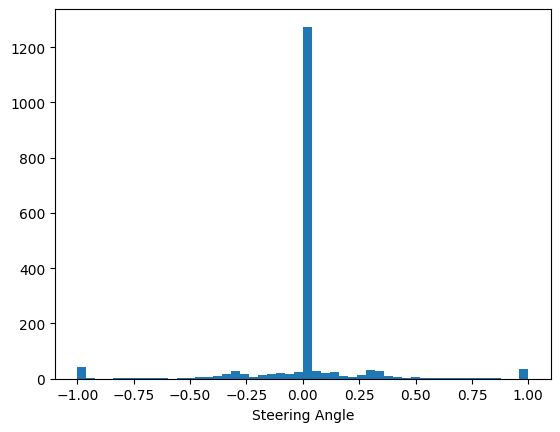

In [276]:
plt.hist(df['steering'], bins=50)
plt.xlabel('Steering Angle')

Text(0.5, 0, 'Steering Angle')

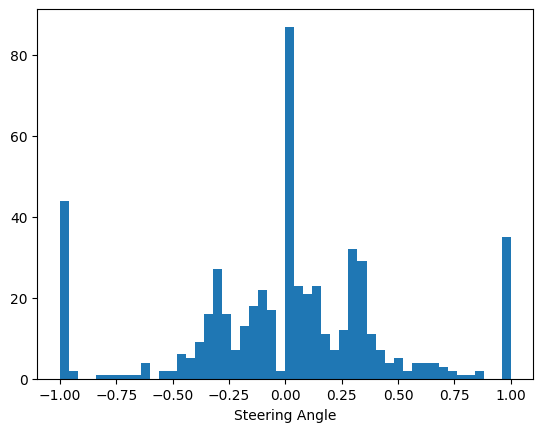

In [277]:
zero_steering = df[np.abs(df['steering']) < 0.05]
non_zero_steering = df[np.abs(df['steering']) >= 0.05]

zero_steering_sample = zero_steering.sample(frac=0.07, random_state=42)
df = pd.concat([zero_steering_sample, non_zero_steering]).sample(frac=1, random_state=42).reset_index(drop=True)
plt.hist(df['steering'], bins=50)
plt.xlabel('Steering Angle')


In [278]:
df = pd.concat([df, df]).sample(frac = 1, random_state=42).reset_index(drop=True)
df.shape

(1094, 7)

Text(0.5, 0, 'Steering Angle')

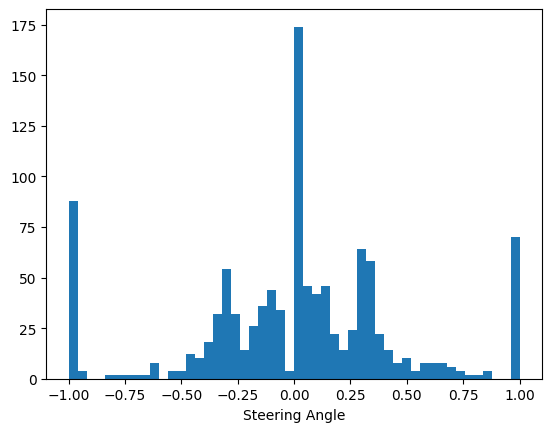

In [279]:
plt.hist(df['steering'], bins=50)
plt.xlabel('Steering Angle')

In [280]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = np.array(image)
    image = image[60 : 135, :, :]
    image = cv.cvtColor(image, cv.COLOR_RGB2YUV)
    image = cv.GaussianBlur(image,  (3, 3), 0)
    image = cv.resize(image, (200, 66))
    image = image / 255.0  # Normalize the image
    return image

In [281]:
X = []
Y = []
for index, row in df.iterrows():
    center = preprocess_image(row['center'].strip())
    left = preprocess_image(row['left'].strip())
    right = preprocess_image(row['right'].strip())
    steering = row['steering']
    X.append([center, left, right])
    Y.append(steering)
len(X), len(Y)
    

(1094, 1094)

In [282]:
import albumentations as A

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=0, p=0.5),
    A.HorizontalFlip(p=0.5),
])


c:\Users\Agastya\OneDrive\Desktop\project\YoloV5\yolo\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


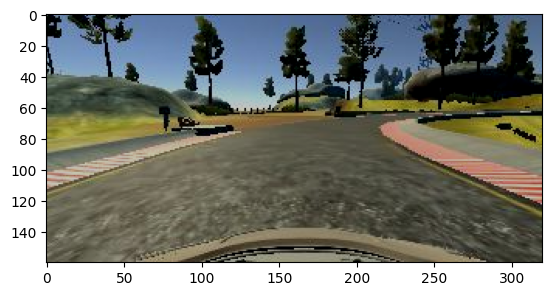

In [283]:
index = np.random.randint(0, len(X)-1)
image = Image.open(df['center'][index].strip())
image = np.array(image)
augmented = transform(image=image)
aug_image = augmented['image']

plt.imshow(aug_image)

In [284]:
def augment_preprocess(image):        
    image = np.array(image)[60:135, :, :]                      
    image = cv.cvtColor(image, cv.COLOR_RGB2YUV)             
    image = cv.GaussianBlur(image, (3, 3), 0)  
    image = cv.resize(image, (200, 66))  # Resize using OpenCV
    image = image / 255.0                                    
    return image


In [285]:
for index, row in df.iterrows():
    center_image = np.array(Image.open(row['center'].strip()).convert("RGB"))
    left_image   = np.array(Image.open(row['left'].strip()).convert("RGB"))
    right_image  = np.array(Image.open(row['right'].strip()).convert("RGB"))
    steering = row['steering']

    augmented_center = augment_preprocess(transform(image = center_image)['image'])
    augmented_left = augment_preprocess(transform(image = left_image)['image'])
    augmented_right = augment_preprocess(transform(image = right_image)['image'])
    X.append([augmented_center,augmented_left, augmented_right])
    Y.append(steering)


In [286]:
import random
combined = list(zip(X, Y))
random.shuffle(combined)
X, Y = zip(*combined)

X = list(X)
Y = list(Y)

In [287]:
X = np.array([x[1] for x in X], dtype=np.float32)
Y = np.array(Y)

In [288]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1750
Valid Samples: 438


Text(0.5, 1.0, 'Validation set')

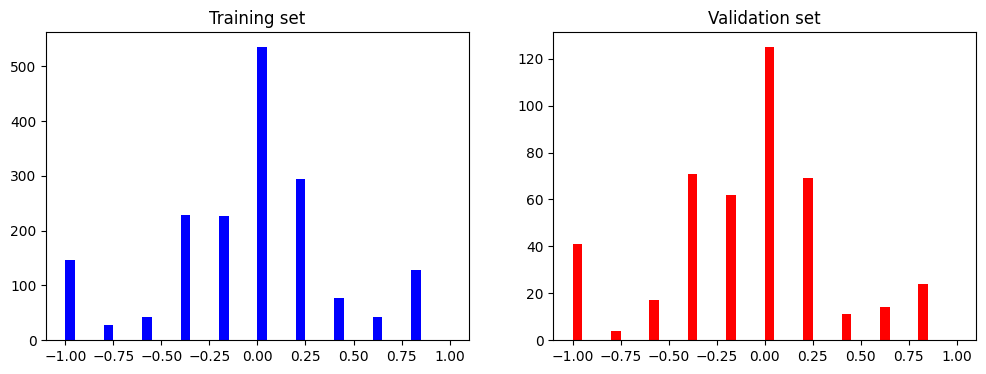

In [289]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, width=0.05, color='red')
axes[1].set_title('Validation set')

In [290]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Conv2D(64, (5, 5), activation='elu'))
  model.add(Flatten())

  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

model = nvidia_model()
print(model.summary())

c:\Users\Agastya\OneDrive\Desktop\project\YoloV5\yolo\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 1, 18, 64)      │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,443 (1.01 MB)

 Trainable params: 264,443 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

None


In [291]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    shuffle=True
)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.6693 - val_loss: 0.2250
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2124 - val_loss: 0.2390
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1896 - val_loss: 0.1908
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1585 - val_loss: 0.1163
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1410 - val_loss: 0.1069
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1098 - val_loss: 0.1080
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1194 - val_loss: 0.0937
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1016 - val_loss: 0.1044
Epoch 9/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1061 - val_loss: 0.1004
Epoch 10/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0910 - val_loss: 0.0849


Text(0.5, 0, 'Epoch')

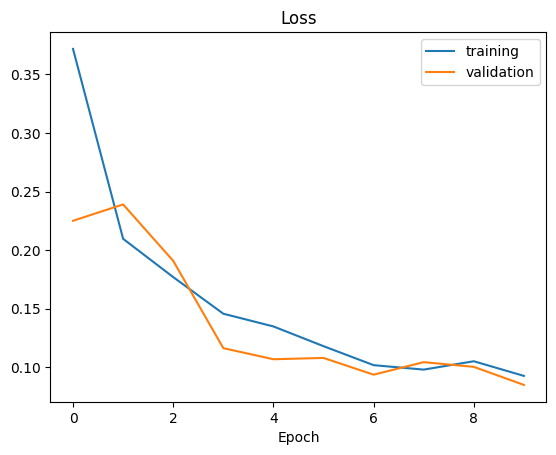

In [292]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Steering Angle: 0.1925
True Steering Angle     : 0.1228


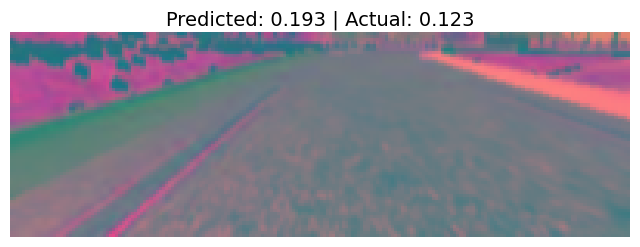

In [302]:
index = random.randint(0, 2000)
pred_angle = model.predict(np.expand_dims(X[index], axis=0))[0][0]
print(f"Predicted Steering Angle: {pred_angle:.4f}")
print(f"True Steering Angle     : {Y[index]:.4f}")
image = X[index]
image = image*255.0
image = np.clip(image, 0, 255).astype(np.uint8)
plt.figure(figsize=(8, 4))
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {pred_angle:.3f} | Actual: {Y[index]:.3f}", fontsize=14)
plt.show()